In [1]:
# Due the different version of python can be found and each machine or libriries 
# I just decided to use this library to avoid distraction and anoing warnigs
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

## Licence of use

Working with Room Occupancy Estimation: That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation
licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/

## About the dataset

    -> The experimental testbed for occupancy estimation was deployed in a 6m x 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers.
    -> The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Occupancy Estimation") \
    .getOrCreate()

24/04/04 22:37:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Loading dataset from HDFS - Biga data Tecnology to storage
df = spark.read.csv("hdfs:///user1/Occupancy_Estimation.csv", header=True, inferSchema=True)

# Preprocessing the dataset with PySpark 
    
     - EDA
     - Cleaning features that won't be used by the LSTM --> Feature Engineering
     - Converting to a Pandas Df to preprocecing
     - Normalization

In [5]:
# Print the schema to understand the data types
df.printSchema()

# Summary statistics for numerical columns
df.describe().show()

root
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)



24/04/04 12:22:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+-------------------+-------------------+--------------------+
|summary|      Date|           S1_Temp|           S2_Temp|            S3_Temp|           S4_Temp|          S1_Light|          S2_Light|         S3_Light|         S4_Light|           S1_Sound|           S2_Sound|           S3_Sound|           S4_Sound|            S5_CO2|        S5_CO2_Slope|             S6_PIR|             S7_PIR|Room_Occupancy_Count|
+-------+----------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+---

In [ ]:
from pyspark.sql.functions import col, count

# Count the total number of entries
total_entries = df.count()

# Count the number of non-null (non-missing) values in each column
non_missing_counts = df.agg(*(count(c).alias(c) for c in df.columns))

# To view the results
non_missing_counts.show()

# Calculating missing values by subtracting non-missing from total entries
# This involves converting the DataFrame to a Pandas DataFrame for easier manipulation
non_missing_counts_pandas = non_missing_counts.toPandas()
missing_values = total_entries - non_missing_counts_pandas.iloc[0]
print("Missing values in each column:\n", missing_values)


# Features and Target

 - Target is predict Room Ocuppancy which is(Room_Occupancy_Count)
 - All the sensors readings would be the features to be analysed
 - Let's perform a better Feature Engineering - separating onto differents df

In [5]:
# Separating features and target variable - This step here it's just to don't go and just drop features.
feature_columns = [col for col in df.columns if col not in {'Date', 'Time', 'Room_Occupancy_Count'}]
features_df = df.select(*feature_columns)
target_df = df.select('Room_Occupancy_Count')

In [7]:
# features_df and target_df are a Spark DataFrames also, convert those to Pandas for normalization(Features)
pandas_features_df = features_df.toPandas()
pandas_target_df = target_df.toPandas()

In [8]:
# One-hot encode the target variable to perform classification to a categorical format
pandas_target_df_categorical = pd.get_dummies(pandas_target_df['Room_Occupancy_Count'])

In [9]:
# Normalize the feature data
scaler_features = MinMaxScaler(feature_range=(0, 1))
pandas_features_df_scaled = pd.DataFrame(scaler_features.fit_transform(pandas_features_df),
                                         columns=pandas_features_df.columns)

## Autocorrelation and time steps

    Each observation in this dataset was measured every 30 seconds, in order to capture trends or patterns
    within a 30-minute window, has to follow the formula
### (30 × 60) ÷ 30 = <code>60 time steps.</code> (reading is 30min times 60 seconds divided by 30 seconds)

In [47]:
# Converting the Full spark data set to pandas making a copy
df_spk = spark.read.csv("hdfs:///user1/Occupancy_Estimation.csv", header=True, inferSchema=True)

In [51]:
df_spk

DataFrame[Date: string, Time: timestamp, S1_Temp: double, S2_Temp: double, S3_Temp: double, S4_Temp: double, S1_Light: int, S2_Light: int, S3_Light: int, S4_Light: int, S1_Sound: double, S2_Sound: double, S3_Sound: double, S4_Sound: double, S5_CO2: int, S5_CO2_Slope: double, S6_PIR: int, S7_PIR: int, Room_Occupancy_Count: int]

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# List of sensor columns to correlate with 'Room_Occupancy_Count'
sensor_columns = [
    "S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp",
    "S1_Light", "S2_Light", "S3_Light", "S4_Light",
    "S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound",
    "S5_CO2", "S5_CO2_Slope", "S6_PIR", "S7_PIR"
]

# Dictionary to store the correlation values
correlations = {}

# Calculate correlation for each sensor and store it
for sensor in sensor_columns:
    correlation = df_spk.stat.corr(sensor, "Room_Occupancy_Count")
    correlations[sensor] = correlation

# Find the maximum correlation
max_correlation_value = max(correlations.values())
max_correlation_sensor = [sensor for sensor, corr in correlations.items() if corr == max_correlation_value][0]

# Highlight the maximum correlation in the output
for sensor, correlation in correlations.items():
    if sensor == max_correlation_sensor:
        # Using ANSI escape codes for colors: \033[1m for bold, \033[92m for green, \033[0m to reset
        print(f"\033[1m\033[92mHighest Correlation between {sensor} and Room_Occupancy_Count: {correlation}\033[0m")
    else:
        print(f"Correlation between {sensor} and Room_Occupancy_Count: {correlation}")


Correlation between S1_Temp and Room_Occupancy_Count: 0.7008681816112686
Correlation between S2_Temp and Room_Occupancy_Count: 0.6712634874724777
Correlation between S3_Temp and Room_Occupancy_Count: 0.6520465675239043
Correlation between S4_Temp and Room_Occupancy_Count: 0.5265086555834034
Highest Correlation between S1_Light and Room_Occupancy_Count: 0.8490580523038589
Correlation between S2_Light and Room_Occupancy_Count: 0.788763877382767
Correlation between S3_Light and Room_Occupancy_Count: 0.7930813168051819
Correlation between S4_Light and Room_Occupancy_Count: 0.3557147404498904
Correlation between S1_Sound and Room_Occupancy_Count: 0.5737482916455339
Correlation between S2_Sound and Room_Occupancy_Count: 0.5578530448115523
Correlation between S3_Sound and Room_Occupancy_Count: 0.5316848559795653
Correlation between S4_Sound and Room_Occupancy_Count: 0.46028734590084147
Correlation between S5_CO2 and Room_Occupancy_Count: 0.6601444951524897
Correlation between S5_CO2_Slope and

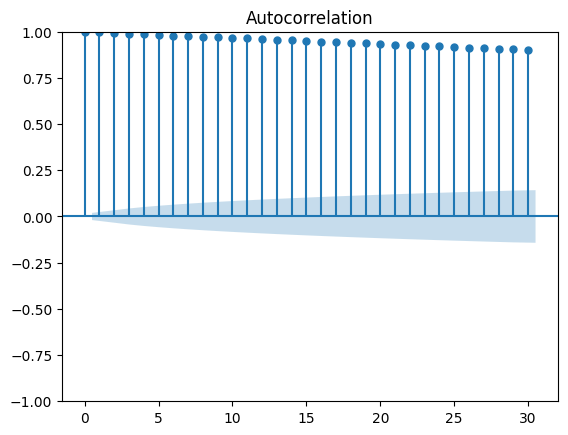

In [33]:
# To understand whcih steps would be better to the model with that data set.

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# `pandas_target_df` is a Pandas df before normalization of target variable
plot_acf(pandas_target_df, lags=30)
plt.show()

## Preparation to aproach  a LSTM model

    Transforming feature and target data into sequences as we have time series data.
    This process involves using all data available to create sequences that LSTM model can learn from it.

In [34]:
# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [35]:
# Create sequences using the scaled features and one-hot encoded target
time_steps = 30
X, y = create_sequences(pandas_features_df_scaled, pandas_target_df_categorical.values, time_steps=time_steps)

In [36]:
# Splitting time series data for LSTM models, ensuring the split preserves the sequence's temporal order
# Determine the split point for an 80/20 train-test split

# Split the data into training and testing sets
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [37]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8079, 30, 16) (8079, 4) (2020, 30, 16) (2020, 4)


# LSTM model architecture

In [38]:
%time
# Define the LSTM model for classification
model = Sequential([
    LSTM(60, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(4, activation='softmax')  # 4 output units for 4 classes
])

# Compile the model with categorical crossentropy loss and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=25, validation_split=0.1, verbose=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Epoch 1/25


2024-04-04 22:46:21.513440: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13960320 exceeds 10% of free system memory.


291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8105 - loss: 0.7446 - val_accuracy: 0.9691 - val_loss: 0.1414
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9259 - loss: 0.3027 - val_accuracy: 0.9691 - val_loss: 0.3245
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9422 - loss: 0.1698 - val_accuracy: 0.9691 - val_loss: 0.3104
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9779 - loss: 0.1191 - val_accuracy: 0.9691 - val_loss: 0.1975
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9826 - loss: 0.0640 - val_accuracy: 0.9691 - val_loss: 0.2288
Epoch 6/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9773 - loss: 0.0850 - val_accuracy: 0.9691 - val_loss: 0.2493
Epoch 7/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9862 - loss: 0.0511 - val_accuracy: 0.9691 - val_loss: 0.3536
Epoch 8/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9859 - loss: 0.0481 - val_accuracy: 0.9691 - val_

### Evaluating on the test set

In [39]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6163 - loss: 1.8401 
Test Accuracy: 86.83%


In [40]:
# Predict and convert probabilities to class labels
y_pred_proba = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

#Convert true labels from one-hot encoding to class labels for comparison
y_true_labels = np.argmax(y_test, axis=1)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [41]:
# Analyzing the results using confusion matrix, classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_labels, y_pred_labels))
print(confusion_matrix(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1751
           1       0.00      0.00      0.00         0
           2       0.11      0.02      0.04        93
           3       0.02      0.01      0.01       176

    accuracy                           0.87      2020
   macro avg       0.26      0.26      0.25      2020
weighted avg       0.81      0.87      0.83      2020

[[1750    0    0    1]
 [   0    0    0    0]
 [   0    0    2   91]
 [ 149    9   16    2]]


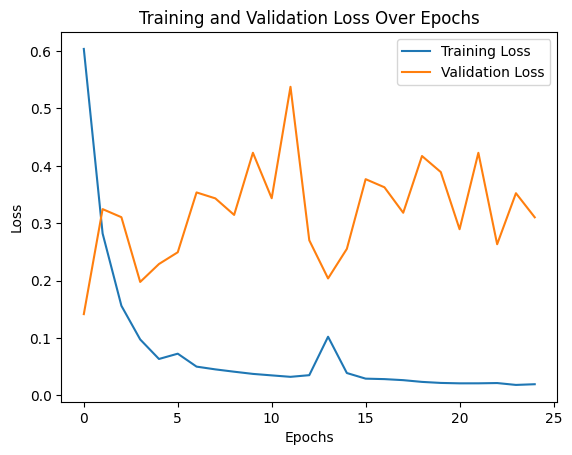

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

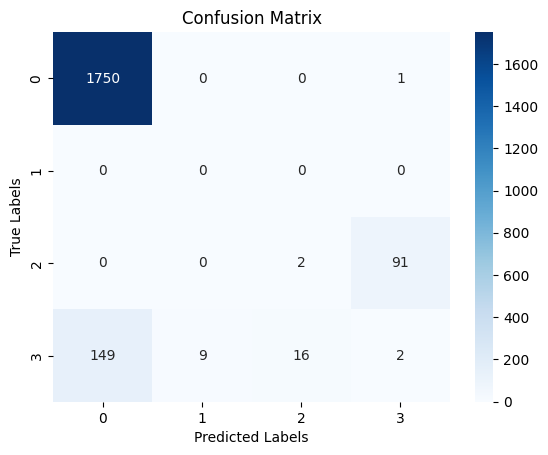

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1751
           1       0.00      0.00      0.00         0
           2       0.55      0.06      0.12        93
           3       0.11      0.06      0.08       180

    accuracy                           0.87      2024
   macro avg       0.40      0.28      0.29      2024
weighted avg       0.84      0.87      0.85      2024

